In [3]:
import math
import lucene
import time
import nltk
import itertools
import numpy as np
from tqdm import tqdm
from java.io import File
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from collections import defaultdict
from org.apache.lucene.store import FSDirectory
from org.apache.lucene.util import BytesRefIterator
from org.apache.lucene.index import DirectoryReader, Term
from org.apache.lucene.analysis.en import EnglishAnalyzer
from org.apache.lucene.analysis.core import WhitespaceAnalyzer
from org.apache.lucene.queryparser.classic import QueryParser
from org.apache.lucene.search import IndexSearcher, BooleanQuery, BooleanClause, TermQuery, BoostQuery
from org.apache.lucene.search.similarities import BM25Similarity, LMJelinekMercerSimilarity, LMDirichletSimilarity
lucene.initVM()

In [4]:
index_path = './index_wt10g'
directory = FSDirectory.open(File(index_path).toPath())
indexReader = DirectoryReader.open(directory)

In [5]:
import pickle
doc_cluster_path = './wt10g_25-500-dim_500_n_init=25.pickle'

with open(doc_cluster_path, 'rb') as handle:
    doc_clusters = pickle.load(handle)

In [7]:
cluster_numbers = doc_clusters[150]
document_dict = {}
for index, cluster_number in enumerate(cluster_numbers):
    if cluster_number not in document_dict:
        document_dict[cluster_number] = [index]
    else:
        document_dict[cluster_number].append(index)


# print(document_dict)

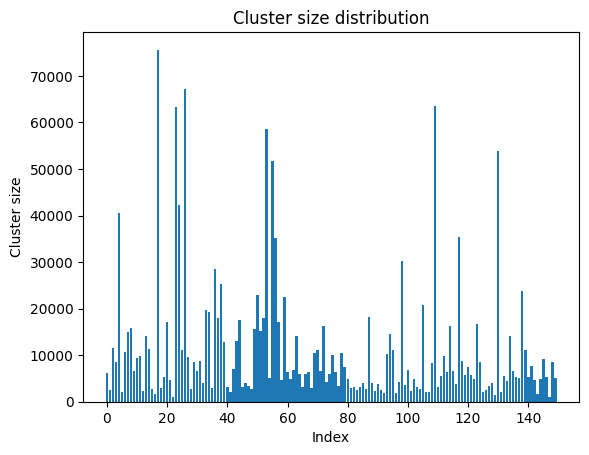

In [8]:
# Extract keys and corresponding list lengths
keys = list(document_dict.keys())
list_lengths = [len(lst) for lst in document_dict.values()]

# Create the histogram
plt.bar(keys, list_lengths)

# Adding labels and title
plt.xlabel('Index')
plt.ylabel('Cluster size')
plt.title('Cluster size distribution')

# Display the histogram
plt.show()

In [58]:
cluster_numbers

array([138, 135,  34, ..., 134,  34,  98], dtype=int32)

In [12]:
len(document_dict)

300

In [26]:
indexReader.getSumTotalTermFreq('CONTENTS')

754377950

In [9]:
from tqdm import tqdm
def concatenate_doc(cluster_dict):
    N = indexReader.numDocs()
    docVec = {}
    D = 0                                 

    for luceneDocid in tqdm(cluster_dict, leave=False):
        
        terms = indexReader.getTermVector(luceneDocid, 'CONTENTS')
        if terms == None:
            print('None term', terms)
        else:
            iterator = terms.iterator()
            for term in BytesRefIterator.cast_(iterator):
                t = term.utf8ToString()
                tf = iterator.totalTermFreq()  
                D += tf
                if t.isalpha() and 10>len(t)>3:
                    if t not in docVec:
                        docVec[t] = tf
                    else:
                        docVec[t] = docVec[t] + tf

    return docVec, D

In [10]:
def P_jm(doc_vec, lamb=0.4):
    totalTF = indexReader.getSumTotalTermFreq("CONTENTS")

    doc_vector, D = doc_vec
    prob_dict =  defaultdict(lambda: [0, 0]) 
 

    for key, value in doc_vector.items():

        cf = indexReader.totalTermFreq(Term('CONTENTS', key))/totalTF
        prob_dict[key][0] = (1- lamb)*(value/D) + lamb*(cf)
        prob_dict[key][1] = cf
    return prob_dict
        

In [11]:
def relative_entropy(p_d):
    rel_ent = {}
    for key, val in p_d.items():
        rel_ent[key] = val[0]*np.log(val[0]/val[1])

    temp_list = sorted(rel_ent.items(), key=lambda x:x[1], reverse=True)
    sorted_rel_ent = dict(temp_list)
    return sorted_rel_ent

In [12]:
# id_query = {}
# for key in tqdm(document_dict):

#     doc = document_dict[key]
#     doc_vec = concatenate_doc(doc)
#     if doc_vec == None:
#         print('Empty doc_vec:', doc_vec)
#     else:
#         p = P_jm(doc_vec)
#         query =  ' '.join(list(relative_entropy(p).keys()))
#         id_query[key] = query

id_query = {}
for key in tqdm(document_dict):

    doc = document_dict[key]
    doc_vec = concatenate_doc(doc)
    if doc_vec == None:
        print('Empty doc_vec:', doc_vec)
    else:
        p = P_jm(doc_vec)
        rel_ent = relative_entropy(p)
        threshold = sum(rel_ent.values())*0.0
        # Filter the dictionary to keep only terms above the threshold
        filtered_data = {term: score for term, score in rel_ent.items() if score > threshold}
        query =  ' '.join(list(filtered_data.keys()))
        id_query[key] = query

  5%|▍         | 7/150 [02:27<36:35, 15.35s/it]  

None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term 

None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term 

None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None


None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term 

None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term 

None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term 

None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None


None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None


None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term 

None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term 

None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term 

None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term 

None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term 

None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term 

None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None


None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None


None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term 

None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None


None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term 

None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term 

None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None
None term None


 31%|███▏      | 47/150 [08:06<08:58,  5.23s/it]

None term None


100%|██████████| 150/150 [14:47<00:00,  5.92s/it]


In [13]:
with open('./generated_query/150_cluster_query_wt10g_10_len_3.pickle', 'wb') as handle:
    pickle.dump(id_query, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('./generated_query/300_cluster_query_wt10g.pickle', 'rb') as handle:
#     id_q = pickle.load(handle)

In [14]:
from tqdm import tqdm
unigram = set()
bigram = set()
for k in tqdm(id_query):
    unigram =  unigram | set(id_query[k].split())  
    
    bigram_temp = list(nltk.bigrams(id_query[k].split()))
    bigram_list = [' '.join(item) for item in bigram_temp]
    bigram = bigram | set(bigram_list)  

100%|██████████| 150/150 [01:05<00:00,  2.31it/s]


In [17]:
len(unigram)+ len(bigram)

7346091

In [18]:
cqg = unigram | bigram

In [22]:
import json
with open('./generated_query/wt10g_cqg_unigram_bigram_10_len_3.json', 'w') as f:
    json.dump(list(cqg), f)

In [151]:
# bigrm = list(nltk.bigrams(query.split()))
